In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import datetime
import ast
from wordcloud import WordCloud, STOPWORDS
import iso639
import json
%matplotlib inline

### EDA 

In [62]:
meta = pd.read_csv('movies_metadata.csv')
meta.head(3)

c:\Python38\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [63]:
meta.id.duplicated().sum()

30

In [64]:
meta['budget'] = pd.to_numeric(meta['budget'], errors='coerce')

In [65]:
meta[meta['budget'] == 0].shape

(36573, 24)

In [66]:
meta['budget'].shape[0] # there are missing values in budget since 80 percent values are 0 we can safely ignore this column

45466

In [67]:
# Drop na's 
title_mask = meta['title'].isna()

In [68]:


meta = meta.loc[title_mask == False]



In [69]:
meta = meta.astype({'id': 'int64'}) # converting to integer in order to merge into crews

In [70]:
crew = pd.read_csv('credits.csv') # importing cast and crew data
crew.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [71]:
crew.id.drop_duplicates(keep = 'first', inplace=True)
meta.id.drop_duplicates(keep = 'first', inplace=True)

In [72]:
crew = crew.drop(meta[meta.original_language.str.count('\d') != 0].index) #drop inaccurate entries containing numbers in language
meta = meta.drop(meta[meta.original_language.str.count('\d') != 0].index)

In [73]:
movies = meta.merge(crew, on='id')
# Make sure it's done successfully
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45514 entries, 0 to 45513
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45514 non-null  object 
 1   belongs_to_collection  4498 non-null   object 
 2   budget                 45514 non-null  float64
 3   genres                 45514 non-null  object 
 4   homepage               7790 non-null   object 
 5   id                     45514 non-null  int64  
 6   imdb_id                45497 non-null  object 
 7   original_language      45514 non-null  object 
 8   original_title         45514 non-null  object 
 9   overview               44561 non-null  object 
 10  popularity             45514 non-null  object 
 11  poster_path            45131 non-null  object 
 12  production_companies   45514 non-null  object 
 13  production_countries   45514 non-null  object 
 14  release_date           45430 non-null  object 
 15  re

In [74]:
movies_clean = movies.copy()

In [75]:
movies_clean = movies_clean.drop(['imdb_id', 'tagline', 'video', 'homepage', 'adult', 'revenue', 'budget'], axis=1) # droppping unwanted columns

In [76]:
movies_clean.drop(movies_clean[movies_clean['status'] != 'Released'].index, inplace=True) # dropping unreleased

In [77]:
movies_clean = movies_clean.drop(['status'], axis=1) # since status is released for all

In [78]:
movies_clean = movies_clean.drop(['belongs_to_collection'], axis=1) # drop franchise movies column

In [79]:
# Drop movies with zero runtime and zero vote count
zero_runtime = movies_clean[movies_clean['runtime'] == 0]
movies_clean.drop(zero_runtime.index, inplace=True)

zero_vote = movies_clean[movies_clean['vote_count'] == 0]
movies_clean.drop(zero_vote.index, inplace=True)

In [80]:
movies_clean.popularity = pd.to_numeric(movies_clean.popularity, errors='coerce') #converting popularity metric to numeric

In [81]:
movies_clean['release_date'] = pd.to_datetime(movies_clean['release_date'],  errors='coerce')
# converting to date time format
movies_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41058 entries, 0 to 45511
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   genres                41058 non-null  object        
 1   id                    41058 non-null  int64         
 2   original_language     41058 non-null  object        
 3   original_title        41058 non-null  object        
 4   overview              40661 non-null  object        
 5   popularity            41058 non-null  float64       
 6   poster_path           40974 non-null  object        
 7   production_companies  41058 non-null  object        
 8   production_countries  41058 non-null  object        
 9   release_date          41034 non-null  datetime64[ns]
 10  runtime               40904 non-null  float64       
 11  spoken_languages      41058 non-null  object        
 12  title                 41058 non-null  object        
 13  vote_average    

In [82]:


# Drop all missing values from the cleaned dataset and reset index
movies_clean.dropna(inplace=True)
movies_clean.reset_index(inplace=True)

In [83]:
movies_clean['year'] = movies_clean['release_date'].dt.year
movies_clean['year'].value_counts()

2014    1756
2013    1737
2015    1675
2012    1562
2011    1509
        ... 
1887       1
1878       1
1874       1
1893       1
1883       1
Name: year, Length: 133, dtype: int64

In [84]:
def get_director(x): # extracting the director
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
#Using abstract syntax tree to get director

movies_clean['director'] = movies_clean['crew'].apply(ast.literal_eval).apply(get_director)
movies_clean['director']

0          John Lasseter
1           Joe Johnston
2          Howard Deutch
3        Forest Whitaker
4          Charles Shyer
              ...       
40568           Ben Rock
40569      Aaron Osborne
40570         John Irvin
40571           Lav Diaz
40572     Mark L. Lester
Name: director, Length: 40573, dtype: object

In [85]:
def get_director_gender(x): #getting the gender of director 
    for i in x:
        if i['job'] == 'Director':
            if i['gender'] == 1:
                return "female"
            elif i['gender'] == 2:
                return "male"
            else:
                return "unknown"
    return np.nan
#using ast to get gender of a director
movies_clean['director_gender'] = movies_clean['crew'].apply(ast.literal_eval).apply(get_director_gender)
movies_clean['director_gender'].value_counts()

male       24011
unknown    14611
female      1558
Name: director_gender, dtype: int64

In [86]:
movies_clean.dropna(inplace=True)
movies_clean.reset_index(inplace=True)

# Check everything looks fine
movies_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40180 entries, 0 to 40179
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   level_0               40180 non-null  int64         
 1   index                 40180 non-null  int64         
 2   genres                40180 non-null  object        
 3   id                    40180 non-null  int64         
 4   original_language     40180 non-null  object        
 5   original_title        40180 non-null  object        
 6   overview              40180 non-null  object        
 7   popularity            40180 non-null  float64       
 8   poster_path           40180 non-null  object        
 9   production_companies  40180 non-null  object        
 10  production_countries  40180 non-null  object        
 11  release_date          40180 non-null  datetime64[ns]
 12  runtime               40180 non-null  float64       
 13  spoken_languages

In [87]:
movies_clean['director_gender'].value_counts()

male       24011
unknown    14611
female      1558
Name: director_gender, dtype: int64

In [89]:
movies_explore = movies_clean.copy()

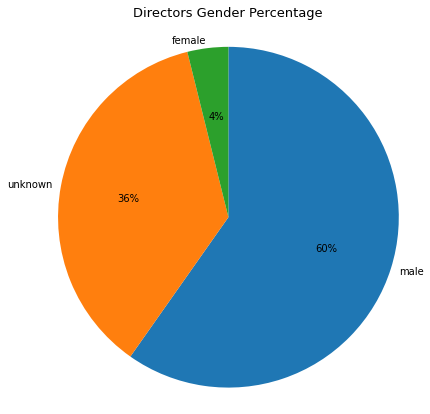

In [99]:
sorted_counts = movies_explore.director_gender.value_counts()
labels = sorted_counts.index

plt.figure(figsize=[7,7])
plt.pie(sorted_counts, labels=labels, startangle=90, counterclock=False, autopct='%1.00f%%', labeldistance= 1.05)
plt.axis('square')
plt.title('Directors Gender Percentage', pad=10, fontsize=13);

In [91]:
#when we remove unknown gender, we get ratio of male to female 
movies_explore_1 =movies_clean.drop(movies_clean[ movies_clean['director_gender'] == 'unknown' ].index)

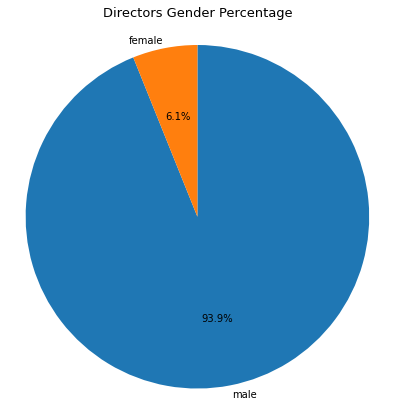

In [97]:
sorted_counts = movies_explore_1.director_gender.value_counts()
labels = sorted_counts.index

plt.figure(figsize=[7,7])
plt.pie(sorted_counts, labels=labels, startangle=90, counterclock=False, autopct='%1.01f%%', labeldistance= 1.05)
plt.axis('square')
plt.title('Directors Gender Percentage', pad=10, fontsize=13);

Text(0, 0.5, 'Frequency')

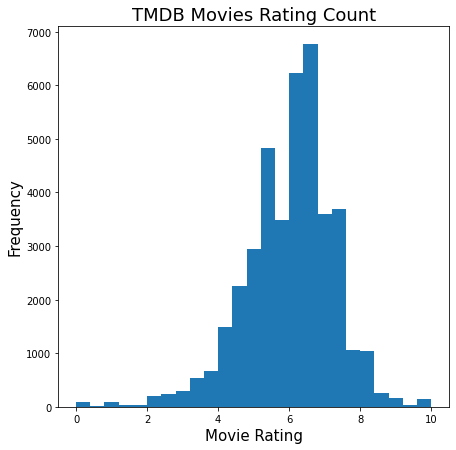

In [101]:
plt.figure(figsize=[7,7])
bins = np.arange(movies_explore.vote_average.min(), movies_explore.vote_average.max() + 0.4, 0.4)
plt.hist(movies_explore.vote_average, bins=bins)
plt.title('TMDB Movies Rating Count', fontsize=18)
plt.xlabel('Movie Rating', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

Text(0, 0.5, 'Count')

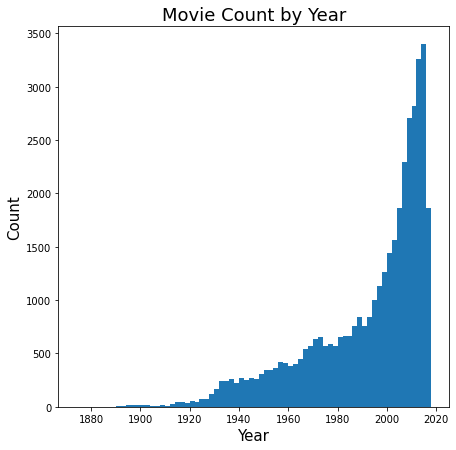

In [102]:
plt.figure(figsize=[7,7])

bins = np.arange(movies_explore.year.min(), movies_explore.year.max() + 2, 2)
plt.hist(movies_explore.year, bins=bins)
plt.title('Movie Count by Year', fontsize=18)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)


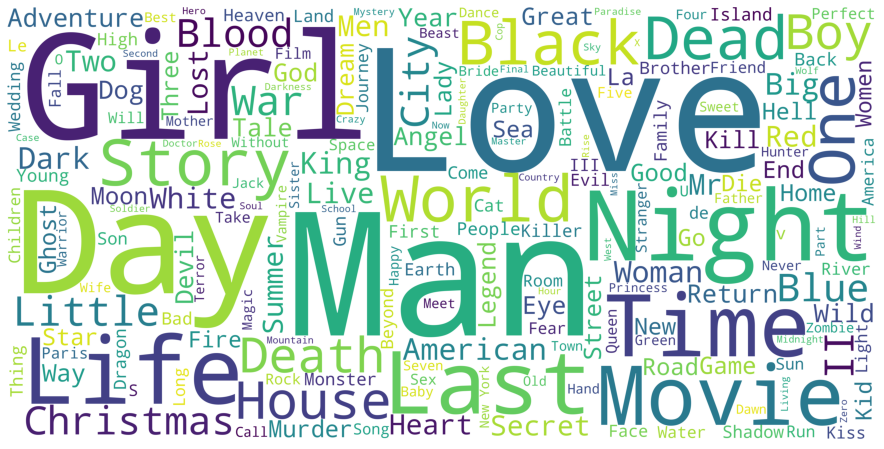

In [105]:
title_corpus = ' '.join(movies_explore['title'])
original_corpus = ' '.join(movies_explore['original_title'])

title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(20,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

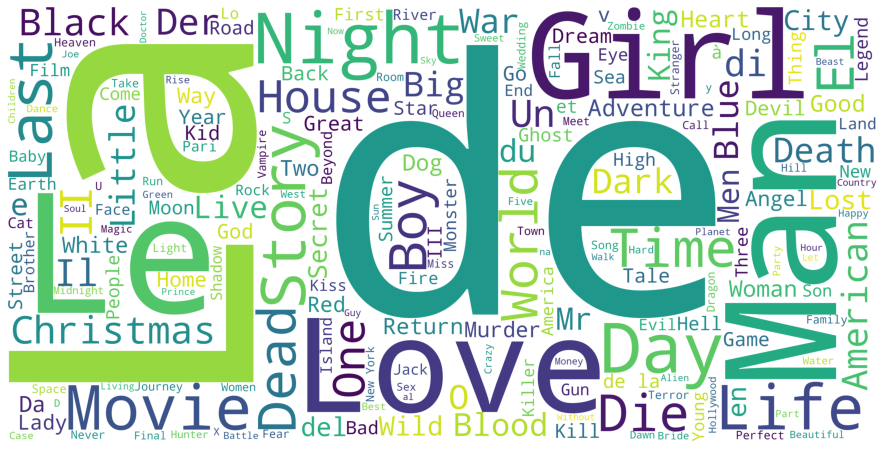

In [106]:
original_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(original_corpus)
plt.figure(figsize=(20,8))
plt.imshow(original_wordcloud)
plt.axis('off')
plt.show()

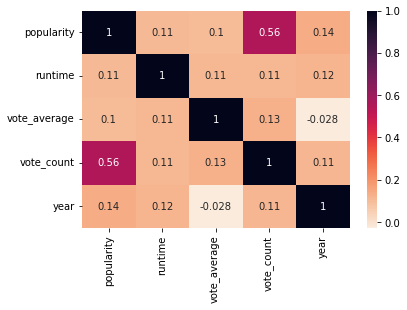

In [107]:
movie_features = movies_explore[['popularity', 'runtime', 'vote_average', 'vote_count', 'year']]
  
#ploting the heatmap for correlation
ax = sb.heatmap(movie_features.corr(), annot=True, cmap='rocket_r')

<AxesSubplot:xlabel='director_gender', ylabel='vote_average'>

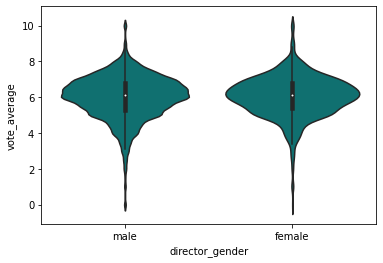

In [115]:
base_color= sb.color_palette()[8] # gender vs vote average
sb.violinplot(data=movies_explore_1, x='director_gender', y='vote_average', color='teal')

## Recommendation Model Apriori

In [117]:
ratings_df = pd.read_csv("ratings_small.csv")

In [118]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [151]:
movies_df = pd.read_csv("movies_metadata.csv") # creating new df for model preprocessing

c:\Python38\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [121]:
movies_df.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [153]:

movies_df.drop(movies_df.index[19730],inplace=True) # id's are corrupted at this indices
movies_df.drop(movies_df.index[29502],inplace=True)
movies_df.drop(movies_df.index[35585],inplace=True)

In [154]:
movies_df.id = movies_df.id.astype(np.int64)

In [155]:
ratings_df = pd.merge(ratings_df,movies_df[['title','id']],left_on='movieId',right_on='id') #merging metadata with ratings to get related ratings of the movie
ratings_df.head()

,userId,movieId,rating,timestamp,title,id
0,1,1371,2.5,1260759135,Rocky III,1371
1,4,1371,4.0,949810302,Rocky III,1371
2,7,1371,3.0,851869160,Rocky III,1371
3,19,1371,4.0,855193404,Rocky III,1371
4,21,1371,3.0,853852263,Rocky III,1371


In [156]:
ratings_df.drop(['timestamp','id'],axis=1,inplace=True)

In [157]:
len(ratings_df)

44994

In [158]:
ratings_df.isnull().sum()

userId     0
movieId    0
rating     0
title      0
dtype: int64

In [159]:

ratings_count = ratings_df.groupby(by="title")['rating'].count().reset_index().rename(columns={'rating':'totalRatings'})[['title','totalRatings']]

In [160]:

len(ratings_count) 

2794

In [161]:

len(ratings_df['title'].unique()) # we check that there are ratings for each movie

2794

In [163]:
ratings_df.head()

,userId,movieId,rating,title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III
3,19,1371,4.0,Rocky III
4,21,1371,3.0,Rocky III


In [162]:
ratings_count.head()

,title,totalRatings
0,!Women Art Revolution,2
1,'Gator Bait,1
2,'Twas the Night Before Christmas,2
3,...And God Created Woman,1
4,00 Schneider - Jagd auf Nihil Baxter,2


In [164]:
ratings_total = pd.merge(ratings_df,ratings_count,on='title',how='left')

In [165]:
ratings_total.shape

(44994, 5)

In [166]:
ratings_total.head()

,userId,movieId,rating,title,totalRatings
0,1,1371,2.5,Rocky III,47
1,4,1371,4.0,Rocky III,47
2,7,1371,3.0,Rocky III,47
3,19,1371,4.0,Rocky III,47
4,21,1371,3.0,Rocky III,47


In [167]:
ratings_count['totalRatings'].describe() #

count    2794.000000
mean       16.103794
std        31.481306
min         1.000000
25%         1.000000
50%         4.000000
75%        15.750000
max       324.000000
Name: totalRatings, dtype: float64

<AxesSubplot:>

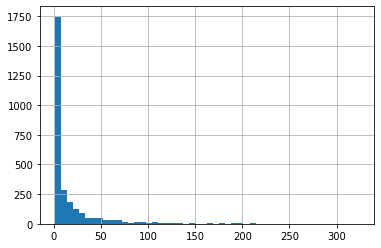

In [171]:
ratings_count['totalRatings'].hist(bins=50) # we can see that there is big difference between min number of ratings maximum number of ratings

In [172]:
ratings_top = ratings_total.query('totalRatings > 20') # we should only take movies having at least 20 -25 votings so that it will be useful for algorithm, we tke 20 as threshold

In [173]:
ratings_top.shape

(34552, 5)

In [174]:
ratings_top.head()

,userId,movieId,rating,title,totalRatings
0,1,1371,2.5,Rocky III,47
1,4,1371,4.0,Rocky III,47
2,7,1371,3.0,Rocky III,47
3,19,1371,4.0,Rocky III,47
4,21,1371,3.0,Rocky III,47


In [175]:
ratings_top = ratings_top.drop_duplicates(['userId','title']) #making sure there are unique entries

In [176]:
ratings_top.shape

(34412, 5)

In [177]:
# Pivoting the data for making it usable for algorithm
df_for_ar = ratings_top.pivot(index='title',columns='userId',values='rating').fillna(0)
df_for_ar.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
"20,000 Leagues Under the Sea",0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
24 Hour Party People,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
28 Days Later,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28 Weeks Later,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
df_for_ar.shape

(580, 671)

In [179]:
def encode_units(x): # function to assign rating as 1 when it has been rated by user
    if x<=0:
        return 0
    if x>=1:
        return 1

In [180]:
df_ar_copy =df_for_ar
df_for_ar = df_for_ar.T.applymap(encode_units)

In [183]:
df_for_ar.shape

(671, 580)

In [184]:
df_for_ar.head()

title,"20,000 Leagues Under the Sea",2001: A Space Odyssey,24 Hour Party People,28 Days Later,28 Weeks Later,300,48 Hrs.,5 Card Stud,7 Virgins,8 Women,...,Within the Woods,X-Men Origins: Wolverine,Y Tu Mamá También,Yankee Doodle Dandy,Yesterday,Young Adam,Young Frankenstein,Young and Innocent,Zatoichi,xXx
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0.0,0.0,0,0.0,0.0,0
2,0.0,1,0,0,0.0,0,1,0.0,0,0,...,0,0,0.0,0,0.0,0.0,0,0.0,0.0,0
3,0.0,0,0,0,0.0,1,0,0.0,0,0,...,0,0,0.0,0,0.0,0.0,0,1.0,0.0,0
4,1.0,0,0,0,0.0,0,0,0.0,0,0,...,0,1,0.0,0,0.0,0.0,1,0.0,0.0,0
5,0.0,0,0,0,0.0,0,1,0.0,0,0,...,0,0,0.0,0,0.0,0.0,0,1.0,0.0,0


In [186]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [189]:
df_for_ar = df_for_ar.fillna(value=0)

In [190]:
frequent_itemsets = apriori(df_for_ar, min_support=0.07, use_colnames=True)

c:\Python38\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [191]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(48 Hrs.),"(20,000 Leagues Under the Sea)",0.298063,0.129657,0.076006,0.255000,1.966724,0.037360,1.168245
1,"(20,000 Leagues Under the Sea)",(48 Hrs.),0.129657,0.298063,0.076006,0.586207,1.966724,0.037360,1.696349
2,(A Nightmare on Elm Street),"(20,000 Leagues Under the Sea)",0.266766,0.129657,0.081967,0.307263,2.369807,0.047379,1.256382
3,"(20,000 Leagues Under the Sea)",(A Nightmare on Elm Street),0.129657,0.266766,0.081967,0.632184,2.369807,0.047379,1.993480
4,(Back to the Future Part II),"(20,000 Leagues Under the Sea)",0.210134,0.129657,0.077496,0.368794,2.844379,0.050251,1.378858


In [194]:
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(48 Hrs.),"(20,000 Leagues Under the Sea)",0.298063,0.129657,0.076006,0.255000,1.966724,0.037360,1.168245
1,"(20,000 Leagues Under the Sea)",(48 Hrs.),0.129657,0.298063,0.076006,0.586207,1.966724,0.037360,1.696349
2,(A Nightmare on Elm Street),"(20,000 Leagues Under the Sea)",0.266766,0.129657,0.081967,0.307263,2.369807,0.047379,1.256382
3,"(20,000 Leagues Under the Sea)",(A Nightmare on Elm Street),0.129657,0.266766,0.081967,0.632184,2.369807,0.047379,1.993480
4,(Back to the Future Part II),"(20,000 Leagues Under the Sea)",0.210134,0.129657,0.077496,0.368794,2.844379,0.050251,1.378858
5,"(20,000 Leagues Under the Sea)",(Back to the Future Part II),0.129657,0.210134,0.077496,0.597701,2.844379,0.050251,1.963381
6,"(Bang, Boom, Bang)","(20,000 Leagues Under the Sea)",0.256334,0.129657,0.073025,0.284884,2.197207,0.039790,1.217065
7,"(20,000 Leagues Under the Sea)","(Bang, Boom, Bang)",0.129657,0.256334,0.073025,0.563218,2.197207,0.039790,1.702604
8,(Batman Returns),"(20,000 Leagues Under the Sea)",0.298063,0.129657,0.073025,0.245000,1.889598,0.034379,1.152772
9,"(20,000 Leagues Under the Sea)",(Batman Returns),0.129657,0.298063,0.073025,0.563218,1.889598,0.034379,1.607067


In [210]:
#lets fetch corresponding association rules generated via Apriori algorithm for Batman Returns
all_antecedents = [list(x) for x in rules['antecedents'].values]
desired_indices = [i for i in range(len(all_antecedents)) if len(all_antecedents[i])==1 and all_antecedents[i][0]=='Batman Returns']
apriori_recommendations=rules.iloc[desired_indices,].sort_values(by=['lift'],ascending=False)
apriori_recommendations.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1908618,(Batman Returns),"(Monsoon Wedding, The Hours, Sissi, Silent Hil...",0.298063,0.087928,0.087928,0.295,3.355,0.061720,1.293718
2333319,(Batman Returns),"(Monsoon Wedding, The Hours, Sissi, Silent Hil...",0.298063,0.077496,0.077496,0.260,3.355,0.054398,1.246627
1803217,(Batman Returns),"(Monsoon Wedding, Bang, Boom, Bang, Sissi, Res...",0.298063,0.071535,0.071535,0.240,3.355,0.050213,1.221664
2459067,(Batman Returns),"(Monsoon Wedding, The Hours, Sissi, Silent Hil...",0.298063,0.071535,0.071535,0.240,3.355,0.050213,1.221664
1914630,(Batman Returns),"(Monsoon Wedding, Sissi, Reservoir Dogs, To Ki...",0.298063,0.071535,0.071535,0.240,3.355,0.050213,1.221664


In [211]:
apriori_single_recommendations = apriori_recommendations.iloc[[x for x in range(len(apriori_recommendations_list)) if len(apriori_recommendations_list[x])==1],]
apriori_single_recommendations_list = [list(x) for x in apriori_single_recommendations['consequents'].values]
print("Apriori single-movie Recommendations for movie: Batman Returns\n")
for i in range(5):
    print("{0}: {1}, with lift of {2}".format(i+1,apriori_single_recommendations_list[i][0],apriori_single_recommendations.iloc[i,6]))

Apriori single-movie Recommendations for movie: Batman Returns

1: Grbavica: The Land of My Dreams, with lift of 2.8757142857142863
2: Knockin' on Heaven's Door, with lift of 2.8158035714285714
3: The Terminal, with lift of 2.731928571428572
4: The Grapes of Wrath, with lift of 2.684
5: Reservoir Dogs, with lift of 2.6094444444444447


In [212]:
apriori_single_recommendations

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1729,(Batman Returns),(Grbavica: The Land of My Dreams),0.298063,0.104322,0.089419,0.300,2.875714,0.058324,1.279540
1739,(Batman Returns),(Knockin' on Heaven's Door),0.298063,0.083458,0.070045,0.235,2.815804,0.045169,1.198095
1853,(Batman Returns),(The Terminal),0.298063,0.104322,0.084948,0.285,2.731929,0.053853,1.252697
1833,(Batman Returns),(The Grapes of Wrath),0.298063,0.096870,0.077496,0.260,2.684000,0.048623,1.220445
1790,(Batman Returns),(Reservoir Dogs),0.298063,0.228018,0.177347,0.595,2.609444,0.109384,1.906129
...,...,...,...,...,...,...,...,...,...
1855,(Batman Returns),(The Thomas Crown Affair),0.298063,0.208644,0.077496,0.260,1.246143,0.015307,1.069400
1751,(Batman Returns),(Men in Black II),0.298063,0.333830,0.120715,0.405,1.213192,0.021213,1.119613
1717,(Batman Returns),(Dawn of the Dead),0.298063,0.238450,0.084948,0.285,1.195219,0.013875,1.065105
1811,(Batman Returns),(Sleepless in Seattle),0.298063,0.298063,0.105812,0.355,1.191025,0.016971,1.088275


## Cosine Similarity

In [213]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [214]:
df2=pd.read_csv('movies_metadata.csv')

c:\Python38\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [215]:
df2['overview'][0]

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

In [216]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

tfidf_matrix.shape

(45466, 75827)

In [217]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [218]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

In [221]:
indices.head()

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64

In [222]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [223]:
get_recommendations('Batman Returns')

21194    Batman Unmasked: The Psychology of the Dark Kn...
41982    Batman Beyond Darwyn Cooke's Batman 75th Anniv...
15511                           Batman: Under the Red Hood
40974    LEGO DC Comics Super Heroes: Batman: Be-Leaguered
18252                                The Dark Knight Rises
Name: title, dtype: object